## Name: Andrew Caide
### CSCI S-89C Deep Reinforcement Learning  
### Part II of Assignment 8

# Problem 1 (20 points)

In this problem we again consider patients with end-stage liver disease (ESLD). We assume that patient's health condition is fully characterized by the Model for End-stage Liver Disease (MELD) score (Jae-Hyeon Ahn and John Hornberger, Involving patients in the cadaveric kidney transplant allocation process: a decision-theoretic perspective. Manage Sci. 1996;42(5):629–41).

The MELD score ranges from 6 to 40 and is derived based on the probability of survival at 3 months for patients with ESLD. Data in ESLD is usually sparse and often aggregated into Stages. We assume that there are 18 stages based on the ESLD: Stage 1, Stage2, ..., Stage 18. The time step is 1 year and the actions in Stages 1 through 18 are "wait" (denoted by 0) and "transplant" (denoted by 1). 

We assume that the Markov property holds. There are two additional states of the Markov Decision Process: "Posttransplant Life" (denoted by 19) and "Death" (which is denoted by 20 and combines so caled "Pretransplant Death" and "Posttransplant Death"). The only action availible in state "Posttransplant Life" is "wait" and "Death" is the terminal state with no actions. Assume that the length of an episode is T=50, unless it terminates earlier due to the transition to the absorbing state "Death."

We do not know the transition probabilities, but if a patient selects "wait," the possible transitions are   
1) Stage 1->Stage 1, Stage 1->Stage 2, Stage 1->Death  
2) For k in {2,3,4,...17}, Stage k->Stage (k-1), Stage k->Stage k, Stage k->Stage (k+1), Stage k->Death    
3) Stage 18->Stage 17, Stage 18->Stage 18, Stage 18->Death    

If a patient selects "transplant" at Stage k, k=1,2,...,18, the only possible transition is  
4) Stage k->"Posttransplant Life"

Finally, there are two more possible transitions"  
5) "Posttransplant Life"->"Posttransplant Life" and "Posttransplant Life"->"Death"  


The patient gets reward 1 in all states "Stage k" (k=1,2,...,18) and reward 0.2 in the "Posttransplant Life" state - assume that the patient gets these rewards on "exit" from the states, i.e. after we observe the corresponding stage. We assume the discounting parameter $\gamma=0.97$, one of the most common discounting rate used in medical decision making (Gold MR, Siegel JE, Russell LB, Weinstein MC. Cost-Effectiveness in Health and Medicine. Oxford University Press; New York: 1996).


Please consider statistics on 8,000 patients with ESLD saved in the 'ESLD_statistics.csv' file. Eeach row represents an episode (i.e. one patient) and the columns are the sequences of the patients' states and actions. This data were generated under the following policy:

$\pi(1|k)=0.02$ for $k\in\{1,2,3,4,5,6,7,8,9,10,11,12,13\}$;   
$\pi(1|14)=0.05$;   
$\pi(1|15)=0.10$;   
$\pi(1|16)=0.20$;   
$\pi(1|17)=0.40$;  
$\pi(1|18)=0.60$;  

which means that, for example, 5% of paients at stage 14 received a transplant.
    

Please estimate $v_\pi(s)$ via the following algorithms using experience replay in all cases - perform in steps:    

(a) Initialize state-values at 0 and run the tabular TD($\lambda$) with $\lambda=0.8$ for estimating $v_\pi(s)$, $s\in\{1,2,\ldots,20\}$. Experiment with $\alpha$ and plot the estimates of $v_\pi(s)$ versus time step.    

(b) Consider the following approximation to the state-values:

$$v_\pi(s)\approx\hat{v}(s,{\bf w}) = \sum_{k=1}^{18} \left(w_1+w_2\, \frac{k-9}{5}+w_3\, \left(\frac{k-9}{5}\right)^2\right)\cdot \mathbb{1}_{(s=\text{"Stage }k\text{"})}+w_4\cdot \mathbb{1}_{(s=\text{"Posttransplant Life"})},$$

and run the TD($\lambda$) with approximation for $v_\pi(s)$, $s\in\{1,2,\ldots,20\}$. Again, use $\lambda=0.8$ and experiment with $\alpha$ - this algorithm is stochastic, so please consider decreasing with time parameter $\alpha$. Experiment with the choice of initial values of weights ${\bf w}=(w_1,w_2,w_3,w_4)^T$ at time $0$. Plot the weights versus time step in one graph. 
     
(c) Run the tabular 1-step TD and plot results for estimated values $v_\pi(s)$ (versus stage k) by theses three methods, (a), (b), and (c), in one graph. Make sure to add title, label axes, and add legend indicating algorithms used. Discuss. 

### (a) Tabular TD($\lambda$)

#### Task:
Please estimate $v_\pi(s)$ via the following algorithms using experience replay in all cases - perform in steps:    

(a) Initialize state-values at 0 and run the tabular TD($\lambda$) with $\lambda=0.8$ for estimating $v_\pi(s)$, $s\in\{1,2,\ldots,20\}$.   
(a.b) Experiment with $\alpha$ and plot the estimates of $v_\pi(s)$ versus time step.  

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("ESLD_statistics.csv")
df.head()

,S0,A0,S1,A1,S2,A2,S3,A3,S4,A4,...,A45,S46,A46,S47,A47,S48,A48,S49,A49,S50
0,12,0,12,0,13,0,13,0,20,0,...,0,20,0,20,0,20,0,20,0,20
1,3,0,3,0,3,0,3,0,3,0,...,0,20,0,20,0,20,0,20,0,20
2,16,0,16,0,16,1,19,0,19,0,...,0,20,0,20,0,20,0,20,0,20
3,13,0,13,0,13,0,13,0,14,0,...,0,20,0,20,0,20,0,20,0,20
4,4,0,4,0,4,0,20,0,20,0,...,0,20,0,20,0,20,0,20,0,20


I am modeling this based off the solution from assignment 6; my solution was a little convoluted, and ultimately wrong

In [2]:
def get_episode(df, k):
    states = df.values[k,0:-1:2]
    actions = df.values[k,1::2]
    rewards = (states <= 18)*1 + (states == 19)*0.2
    return [states, actions, rewards]

This solutions follows Slide 25 of Lecture 8:

Quote: The $\lambda$-return algoritm is    
$$[1]V_{t+s}(S_{t}) \leftarrow V_{t+n-1}(S_{t}) + \alpha [G_{t}^{\lambda} - V_{t+n-1}(S_{t})]$$

where, for a 1-step td (n=1),    
$$[2]G_{t}^{\lambda} = \sum_{n=1}^{T-t-1} (1-\lambda)G_{t:(t+1)}+\lambda^{T-t-1}G_{t} $$

and    
$$[3]G_{t:(t+1)} = R_{t+1} + \gamma V_{t}(S_{t+1})$$

In [3]:
def onestep_tabular_td(df, alpha):

    lambd = 0.8
    gamma = 0.97
    T = 50
    num_episodes = df.shape[0]
    V = np.zeros(20)
    V_history = V.reshape((20,1))
    N = 0

    for k in range(num_episodes):
        episode = get_episode(df, k)

        for t in range(0,T-1):
            N = N + 1
            S = episode[0][t]
            S1 = episode[0][t+1]
            R = episode[2][t]
            a = episode[1][t]
            
            '''
            Hi Andrew, Your V(S) (as a function of S instead of t?) as shown in the first figure is lower than expected. 
            I believe the error is: "G = (1-lambd)*g + lambd**(T-t-1)*R", 
            where you'd add up all the items with factor (1-lambda), (1-lambda)*lambda, ..., lambda^(T-t-1). 
            -Jie
            '''
            
            # lambda return alg
            g = R + gamma*V[S1-1]                 # [3]
            G = (1-lambd)*g + lambd**(T-t-1)*R    # [2]
            V[S-1] = V[S-1] + alpha*(G - V[S-1] ) # [1]
            
            if (int(N/100)*100==N):
                V_history = np.append(V_history, V.reshape((20,1)), axis=1)
            if S1==20:
                break
    return V

def alpha_scan(df, func):
    res = pd.DataFrame()
    alphas = [0.1, .3, .5, .7, .9, 1]
    for alpha in alphas:
        alpha_res = pd.DataFrame(func(df, alpha))
        alpha_res.columns = ['V']
        alpha_res['Alpha'] = alpha
        alpha_res['T'] = alpha_res.index
        res = res.append(alpha_res, ignore_index = True)
    return res

No handles with labels found to put in legend.


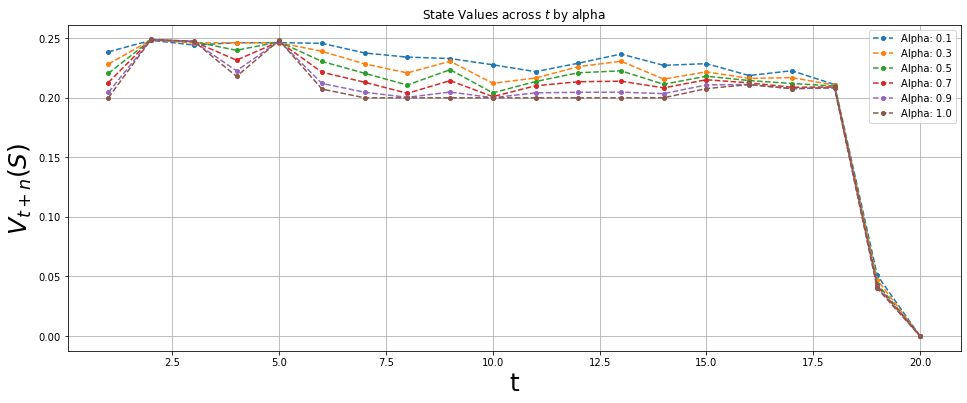

In [4]:
from matplotlib import pyplot as plt 
results = alpha_scan(df, onestep_tabular_td)
groups = results.groupby('Alpha') 

# Plot
fig, ax = plt.subplots(figsize=(16,6))
ax.set_title('State Values across $t$ by alpha')
ax.set_ylabel("$V_{t+n}(S)$",fontsize = 25.0)
ax.set_xlabel("t",fontsize = 25.0)
ax.legend(loc = 'upper right')
ax.grid(True)

for name, group in groups:
    ax.plot(group['T']+1, group['V'], marker='o', linestyle='--', ms=4, label = "Alpha: {}".format(name))
ax.legend()

### (b) TD($\lambda$) with approximation

(b) Consider the following approximation to the state-values:

$$v_\pi(s)\approx\hat{v}(s,{\bf w}) = \sum_{k=1}^{18} \left(w_1+w_2\, \frac{k-9}{5}+w_3\, \left(\frac{k-9}{5}\right)^2\right)\cdot \mathbb{1}_{(s=\text{"Stage }k\text{"})}+w_4\cdot \mathbb{1}_{(s=\text{"Posttransplant Life"})},$$

and run the TD($\lambda$) with approximation for $v_\pi(s)$, $s\in\{1,2,\ldots,20\}$. Again, use $\lambda=0.8$ and experiment with $\alpha$ - this algorithm is stochastic, so please consider decreasing with time parameter $\alpha$. Experiment with the choice of initial values of weights ${\bf w}=(w_1,w_2,w_3,w_4)^T$ at time $0$. 

#### GOAL: Plot the weights versus time step in one graph.

In [5]:
def state_value(k, w):
    v = (w[0] + w[1]*(k-9)/5 + w[2]*(((k-9)/5)**2))*(k<=18) + w[3]*(k==19)
    return v

def del_state_value(k, w):
    dv = [1, (k-9)/5, ((k-9)/5)**2, 0]*int(k<=18) + [0, 0, 0, 1]*int(k==19) + [0, 0, 0, 0]*int(k==20)
    return np.array(dv)

This solution follows the TD($\lambda$) algoritm on slide 27 of lecture 8.
Note:
$$[1] z \leftarrow \gamma \lambda z + \nabla v(S,w)$$
$$[2] \delta \leftarrow R + \gamma v(S',w) - v(S, w)$$
$$[3] w \leftarrow w + \alpha \delta z$$

In [6]:
def td_w_approx(df, alpha):
    l = 0.8
    gamma = 0.97
    T = 50
    num_episodes = df.shape[0]
    N = 0
    weights = np.zeros(4)
    weights_hist = weights.reshape((4,1))

    for k in range(num_episodes):
        episode = get_episode(df, k)
        z = 0
        
        for t in range(0,T-1):
            N = N + 1
            S = episode[0][t]
            S1 = episode[0][t+1]
            R = episode[2][t]

            z = gamma * l * z + del_state_value(S, weights)                  # [1]
            d = R + gamma*state_value(S1, weights) - state_value(S, weights) # [2]
            weights = weights + alpha*d*z                                    # [3]
            
            if (int(N/100)*100==N):
                weights_hist = np.append(weights_hist, weights.reshape((4,1)), axis=1)
            if S1==20:
                break
                
    return [weights, weights_hist]

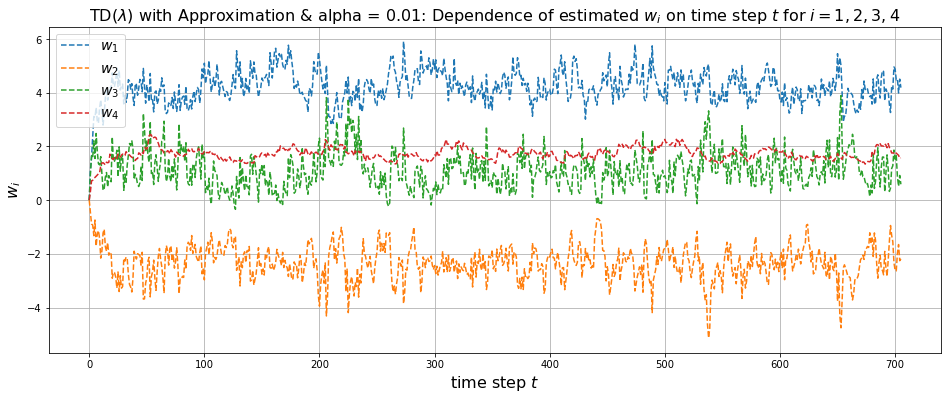

In [7]:
approximation = td_w_approx(df, 0.01)[1]
approximation = pd.DataFrame(approximation).T

plt.figure(figsize=(16,6))
plt.plot(approximation.index, approximation[0], linestyle='--', marker=None, markersize=4,label='$w_1$')
plt.plot(approximation.index, approximation[1], linestyle='--', marker=None, markersize=4,label='$w_2$')
plt.plot(approximation.index, approximation[2], linestyle='--', marker=None, markersize=4,label='$w_3$')
plt.plot(approximation.index, approximation[3], linestyle='--', marker=None, markersize=4,label='$w_4$')
plt.xlabel("time step $t$",fontsize=16)
plt.ylabel("$w_i$",fontsize=16)
plt.title('TD($\lambda$) with Approximation & alpha = 0.01: \
Dependence of estimated $w_i$ on time step $t$ for $i=1,2,3,4$',fontsize=16)
plt.grid(True)
plt.legend(loc = 'upper left',fontsize=14)
plt.show()

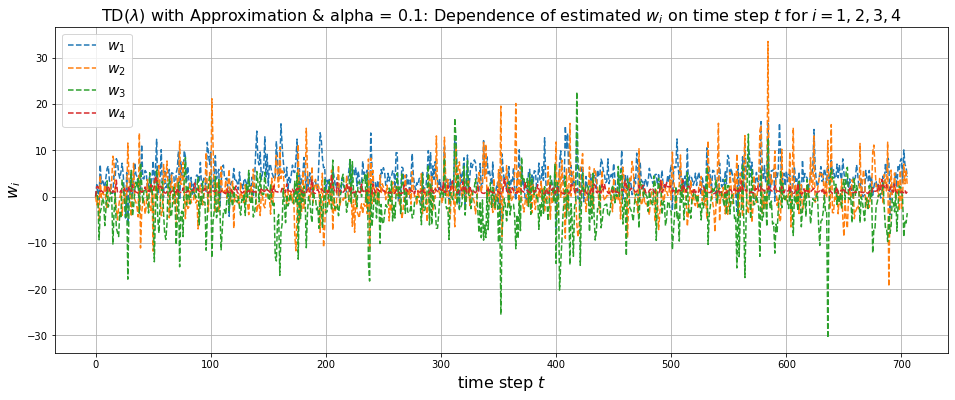

In [8]:
approximation = td_w_approx(df, 0.1)[1]
approximation = pd.DataFrame(approximation).T

plt.figure(figsize=(16,6))
plt.plot(approximation.index, approximation[0], linestyle='--', marker=None, markersize=4,label='$w_1$')
plt.plot(approximation.index, approximation[1], linestyle='--', marker=None, markersize=4,label='$w_2$')
plt.plot(approximation.index, approximation[2], linestyle='--', marker=None, markersize=4,label='$w_3$')
plt.plot(approximation.index, approximation[3], linestyle='--', marker=None, markersize=4,label='$w_4$')
plt.xlabel("time step $t$",fontsize=16)
plt.ylabel("$w_i$",fontsize=16)
plt.title('TD($\lambda$) with Approximation & alpha = 0.1: \
Dependence of estimated $w_i$ on time step $t$ for $i=1,2,3,4$',fontsize=16)
plt.grid(True)
plt.legend(loc = 'upper left',fontsize=14)
plt.show()

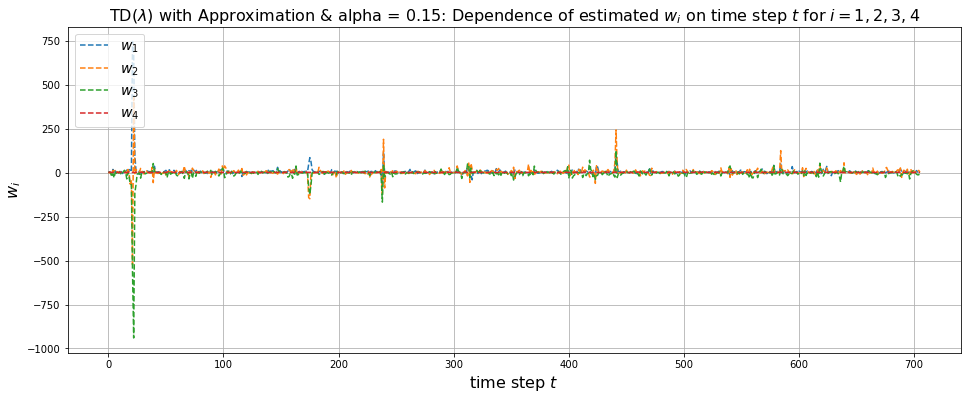

In [9]:
approximation = td_w_approx(df, 0.15)[1]
approximation = pd.DataFrame(approximation).T

plt.figure(figsize=(16,6))
plt.plot(approximation.index, approximation[0], linestyle='--', marker=None, markersize=4,label='$w_1$')
plt.plot(approximation.index, approximation[1], linestyle='--', marker=None, markersize=4,label='$w_2$')
plt.plot(approximation.index, approximation[2], linestyle='--', marker=None, markersize=4,label='$w_3$')
plt.plot(approximation.index, approximation[3], linestyle='--', marker=None, markersize=4,label='$w_4$')
plt.xlabel("time step $t$",fontsize=16)
plt.ylabel("$w_i$",fontsize=16)
plt.title('TD($\lambda$) with Approximation & alpha = 0.15: \
Dependence of estimated $w_i$ on time step $t$ for $i=1,2,3,4$',fontsize=16)
plt.grid(True)
plt.legend(loc = 'upper left',fontsize=14)
plt.show()

#### Note:
As $\alpha$ approaches 1, the weights start growing expoentially. As a matter of fact, it happens as early as $\alpha = 0.3$

### (c) Tabular 1-step TD and comparison

### Task: 
Run the tabular 1-step TD and plot results for estimated values  𝑣𝜋(𝑠)  (versus stage k) by theses three methods, (a), (b), and (c), in one graph. 
Make sure to add title, label axes, and add legend indicating algorithms used. Discuss.

In [10]:
def one_step_td(df, alpha):
    df = df.copy()
    gamma = 0.97
    T = 50
    num_episodes = df.shape[0]
    V = np.zeros(20)
    V_history = V.reshape((20,1))
    N = 0
    
    for k in range(num_episodes):
        episode = get_episode(df, k)
        
        for t in range(0,T-1):
            N = N + 1
            S = episode[0][t]
            S1 = episode[0][t+1]
            R = episode[2][t]
            #print("N: {}, R: {}, V[{}]: {}".format(N, R, S,  round(V[S-1] + alpha*(R + gamma*V[S1-1] - V[S] ) ),2))

            V[S-1] = V[S-1] + alpha*(R + gamma*V[S1-1] - V[S-1] ) 
            
            if (int(N/100)*100==N):
                V_history = np.append(V_history, V.reshape((20,1)), axis=1)
            if S1==20:
                break                                    
    return V

In [11]:
df = pd.read_csv("ESLD_statistics.csv")
one_step = one_step_td(df, 0.1)


In [12]:
import pandas as pd
from sklearn import preprocessing

x = one_step.reshape(-1, 1) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
res = pd.DataFrame(x_scaled)
res.columns = ['1StepTD']

In [14]:
approxing = td_w_approx(df, 0.1)[0]
via_approx = np.array([state_value(k,approxing) for k in range(1,21)])
x = via_approx.reshape(-1, 1)
x_scaled = min_max_scaler.fit_transform(x)
res['Approximation'] = x_scaled

In [15]:
one_step = onestep_tabular_td(df, 0.1)
x = one_step.reshape(-1, 1)
x_scaled = min_max_scaler.fit_transform(x)
res['TDLambda'] = x_scaled

In [16]:
res

,1StepTD,Approximation,TDLambda
0,0.958037,1.000000,0.961023
1,1.000000,0.892537,1.000000
2,0.785751,0.791871,0.984183
3,0.593971,0.698002,0.991971
4,0.608037,0.610928,0.992020
5,0.603937,0.530651,0.989881
6,0.476397,0.457170,0.957191
7,0.360207,0.390486,0.943168
8,0.337745,0.330598,0.938471
9,0.306278,0.277507,0.917230


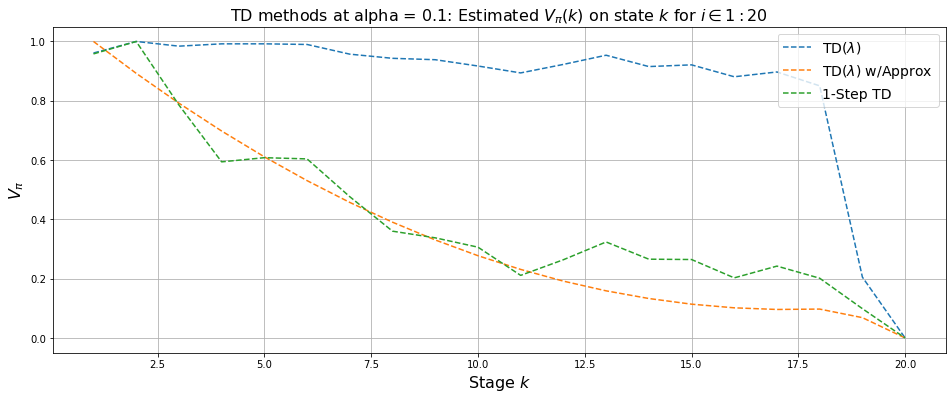

In [17]:
plt.figure(figsize=(16,6))
plt.plot(res.index+1, res['TDLambda'], linestyle='--', marker=None, markersize=4,label='TD($\lambda$)')
plt.plot(res.index+1, res['Approximation'], linestyle='--', marker=None, markersize=4,label='TD($\lambda$) w/Approx')
plt.plot(res.index+1, res['1StepTD'], linestyle='--', marker=None, markersize=4,label='1-Step TD')
plt.xlabel("Stage $k$",fontsize=16)
plt.ylabel("$V_{\pi}$",fontsize=16)
plt.title('TD methods at alpha = 0.1: \
Estimated $V_{\pi}(k)$ on state $k$ for $i\in{1:20}$',fontsize=16)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=14)
plt.show()

I expected TD($\lambda$) to behave much more similarly to the 1-step TD method; evidentyly the approximation method yielded closer results to the 1-Step TD. 